There are some really cool Kernels sitting out there for this competition and they are far slicker and efficient than this. This is just a brief data dive and some features using TFIDF and Truncated SVD on them. 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import xgboost 

import gensim
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import re
import gc
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [3]:
import os
cdir = os.getcwd()
tVars = pd.read_csv('training_variants')
vVars = pd.read_csv('stage2_test_variants.csv')
tText = pd.read_csv('training_text',sep='\|\|',
                    skiprows=1,engine='python',names=["ID","text"])
vText = pd.read_csv('stage2_test_text.csv',sep='\|\|',
                    skiprows=1,engine='python',names=["ID","text"])

<input>:5: DeprecationWarning: invalid escape sequence \|
<input>:5: DeprecationWarning: invalid escape sequence \|
<input>:5: DeprecationWarning: invalid escape sequence \|
<input>:5: DeprecationWarning: invalid escape sequence \|
<input>:7: DeprecationWarning: invalid escape sequence \|
<input>:5: DeprecationWarning: invalid escape sequence \|
<input>:7: DeprecationWarning: invalid escape sequence \|
<input>:5: DeprecationWarning: invalid escape sequence \|
<input>:7: DeprecationWarning: invalid escape sequence \|
<ipython-input-3-b3bf3517e054>:5: DeprecationWarning: invalid escape sequence \|
  tText = pd.read_csv('training_text',sep='\|\|',
<ipython-input-3-b3bf3517e054>:7: DeprecationWarning: invalid escape sequence \|
  vText = pd.read_csv('stage2_test_text.csv',sep='\|\|',


In [4]:
tVars.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
tText.head()

,ID,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
print(tText['text'][0][:20], '   ', len(tText['text'][0]))

Cyclin-dependent kin     39765


It looks like each of these items in the text are going to have fairly lengthy descriptions and we can treat these as documents, or at least I am.

In [7]:
print(len(tText), len(tVars), len(vText), len(vVars))

3321 3321 986 986


In [8]:
from collections import Counter
varsGeneCount = Counter(tVars.Gene)
print(varsGeneCount, '\n', len(varsGeneCount))

Counter({'BRCA1': 264, 'TP53': 163, 'EGFR': 141, 'PTEN': 126, 'BRCA2': 125, 'KIT': 99, 'BRAF': 93, 'ERBB2': 69, 'ALK': 69, 'PDGFRA': 60, 'PIK3CA': 56, 'CDKN2A': 52, 'FGFR2': 50, 'FLT3': 49, 'TSC2': 47, 'MTOR': 45, 'KRAS': 44, 'MAP2K1': 43, 'VHL': 41, 'RET': 40, 'FGFR3': 39, 'MLH1': 35, 'SMAD4': 33, 'MET': 33, 'JAK2': 33, 'NOTCH1': 31, 'AKT1': 28, 'ROS1': 26, 'ABL1': 26, 'PTPN11': 26, 'CBL': 25, 'CTNNB1': 25, 'PIK3R1': 24, 'RUNX1': 24, 'PTPRT': 23, 'SMAD3': 23, 'PDGFRB': 23, 'HRAS': 22, 'NFE2L2': 22, 'MSH2': 21, 'SMO': 21, 'ERBB4': 20, 'TSC1': 20, 'SPOP': 20, 'AR': 20, 'SMAD2': 19, 'FBXW7': 19, 'ERCC2': 19, 'JAK1': 18, 'RHOA': 17, 'SF3B1': 16, 'ESR1': 16, 'PMS2': 16, 'IDH1': 16, 'NF1': 16, 'NTRK1': 16, 'TET2': 14, 'KEAP1': 14, 'MSH6': 13, 'FGFR1': 13, 'CCND1': 13, 'STK11': 13, 'PPP2R1A': 12, 'CARD11': 12, 'RAF1': 12, 'NRAS': 12, 'ERBB3': 11, 'EWSR1': 11, 'AKT2': 11, 'MAP2K2': 11, 'NF2': 11, 'PIK3CB': 10, 'POLE': 10, 'CDK12': 10, 'RB1': 10, 'DICER1': 9, 'CDH1': 9, 'EP300': 9, 'BAP1': 9, 

That will be giving us 264 different categories if we decide to encode the labels. At this point I am not sure I know what they mean either.  What about the classes?

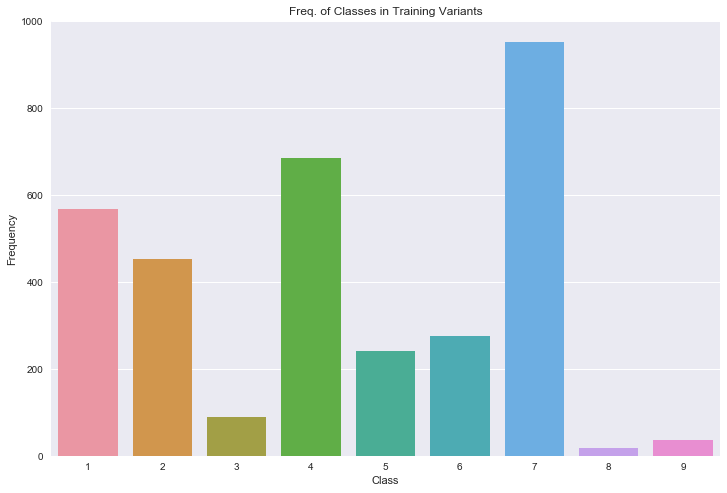

In [9]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x="Class", data=tVars)
plt.ylabel('Frequency'); plt.xlabel('Class')
plt.title('Freq. of Classes in Training Variants')
plt.show()

In [10]:
subfile = pd.read_csv('submission.csv')
subfile.head(3)

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,0.000000,0.257231,0.0,0.000000,0.000000,0.035007,0.702068,0.000000,0.005693
1,1,0.167919,0.116956,0.0,0.403286,0.003950,0.047564,0.239194,0.004589,0.016542
2,2,0.081397,0.251555,0.0,0.219557,0.040011,0.046861,0.352531,0.002473,0.005615


With so many "7" classes there could be an issue of predictions skewed that way which may be something to look at down the road.

In [11]:
varsVariationCount = Counter(tVars.Variation)
print('Number of unique varations in trainVars.Variation: \n', len(varsVariationCount))

Number of unique varations in trainVars.Variation: 
 2996


C:\Users\Wegee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


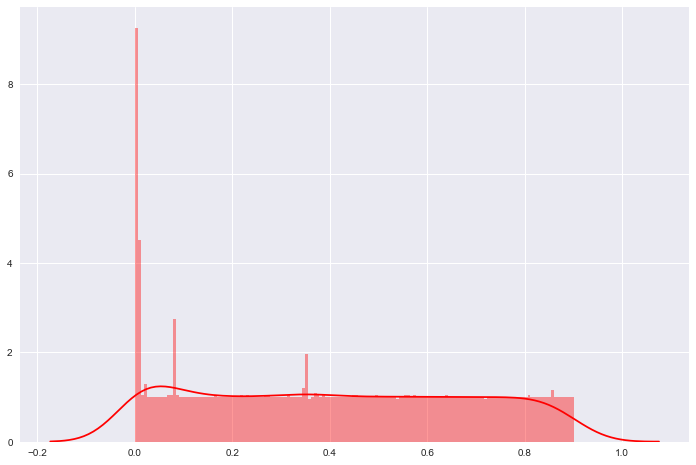

In [12]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.distplot(pd.factorize(tVars['Variation'])[0]/len(tVars), bins=150, color='r')

Once again, many, many different categories here, and it appears there are a lot of unique ones with only 1 count. With so many in "7" it could be a slight disadvantage.

Since there is not that much else to look at in the Training Variants, lets take a little closer look into the Training Text. _I kept getting errors importing the stop words so I just grabbed them._

In [13]:
stopWords = ["fig", "figure", "fig." "et", "al", "table", "fig "
            "data", "analysis", "analyze", "study",  
            "method", "result", "conclusion", "author",  
            "find", "found", "show", "perform",  
            "demonstrate", "evaluate", "discuss", "google", "scholar",   
            "pubmed",  "web", "science", "crossref", "supplementary", "mutation", "mutations", "cells", 
             "cell", "mutations", "mutation", "also", "figure", "using", "fig", "methods",
            "(1)","(2)","(3)","(4)","(5)","(6)","(7)","(8)","(9)","(10)","(11)","(12)","(13)","(14)","(15)",
            "(1).","(2).","(3).","(4).","(5).","(6).","(7).","(8).","(9).","(10).","(11).","(12).","(13).","(14).","(15).",
            "(1)]","(2)]","(3)]","(4)]","(5)]","(6)]","(7)]","(8)]","(9)]","(10)]","(11)]","(12)]","(13)]","(14)]","(15)]",
            "(1)].","(2)].","(3)].","(4)].","(5)].","(6)].","(7)].","(8)].","(9)].","(10)].","(11)].","(12)].","(13)].","(14).","(15)].",
            "1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]
    


def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words('english')+stopWords)
    ## I ketp getting errors on importing the stopwords and I have no clue why
    #stops = set(stopwords.words("English"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    return(text)

In [14]:
trainText = []
for it in tText['text']:
    newT = textClean(it)
    trainText.append(newT)
testText = []
for it in vText['text']:
    newT = textClean(it)
    testText.append(newT)

After a little cleaning, I wonder how the text shapes up now? Are there any other additional words that we could cut out?

In [15]:
trainText[0][:100]

'cyclin-dependent kinases cdks regulate variety fundamental cellular processes  cdk10 stands one last'

So each of the portions of the doc are cleaned and we can check out the most common of a few of them...

In [16]:
for i in range(10):
    print('\n Doc ', str(i))
    stopCheck = Counter(trainText[i].split())
    print(stopCheck.most_common()[:10])


 Doc  0
[('cyclin', 90), ('cdk10', 81), ('fig', 68), ('ets2', 54), ('expression', 43), ('protein', 38), ('levels', 35), ('fam58a', 33), ('star', 33), ('mm', 26)]

 Doc  1
[('c-cbl', 153), ('lung', 56), ('egfr', 43), ('met', 33), ('samples', 33), ('cancer', 32), ('loh', 29), ('patients', 26), ('0', 25), ('domain', 23)]

 Doc  2
[('c-cbl', 153), ('lung', 56), ('egfr', 43), ('met', 33), ('samples', 33), ('cancer', 32), ('loh', 29), ('patients', 26), ('0', 25), ('domain', 23)]

 Doc  3
[('cbl', 104), ('cases', 50), ('aupd', 42), ('upn', 38), ('case', 26), ('11q', 25), ('tyrosine', 22), ('mpns', 21), ('flt3', 21), ('10', 19)]

 Doc  4
[('cbl', 121), ('binding', 64), ('cancer', 62), ('stability', 40), ('effects', 33), ('fig', 32), ('protein', 30), ('activity', 30), ('cbl-e2', 30), ('state', 26)]

 Doc  5
[('cbl', 121), ('binding', 64), ('cancer', 62), ('stability', 40), ('effects', 33), ('fig', 32), ('protein', 30), ('activity', 30), ('cbl-e2', 30), ('state', 26)]

 Doc  6
[('cbl', 121), ('

There looks like a lot of similarity here just by a quick visual examination. 

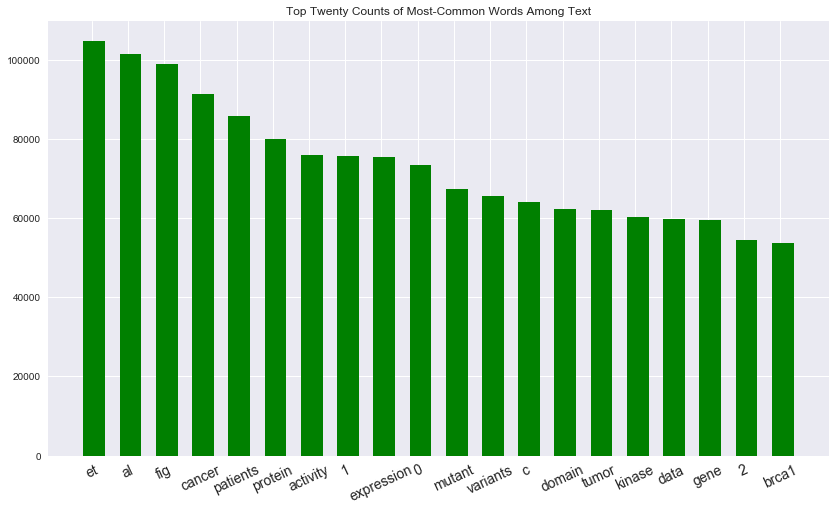

In [17]:
tops = Counter(str(trainText).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='g')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among Text')

In [18]:
gc.collect()

28963

There is some weight on the far left of this plot. Lets throw these words into another stop word check and re examine. If we really worked this into the mix, we could probably use the max_df setting in the TFIDF and Count Vectorizers below. 

A few time through this and I think we should drop some more words than just the top 20. Lets try 30.

In [19]:
topsInc = Counter(str(trainText).split()).most_common()[:50]
labsInc, valsInc = zip(*topsInc)

In [20]:
gc.collect()

0

In [21]:
def stopCheck(text, stops):
    text = text.split()
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return text

In [22]:
trainText2 = []
for it in trainText:
    newT = stopCheck(it,labsInc)
    trainText2.append(newT)
    
testText2 = []
for it in testText:
    newT = stopCheck(it,labsInc)
    testText2.append(newT)

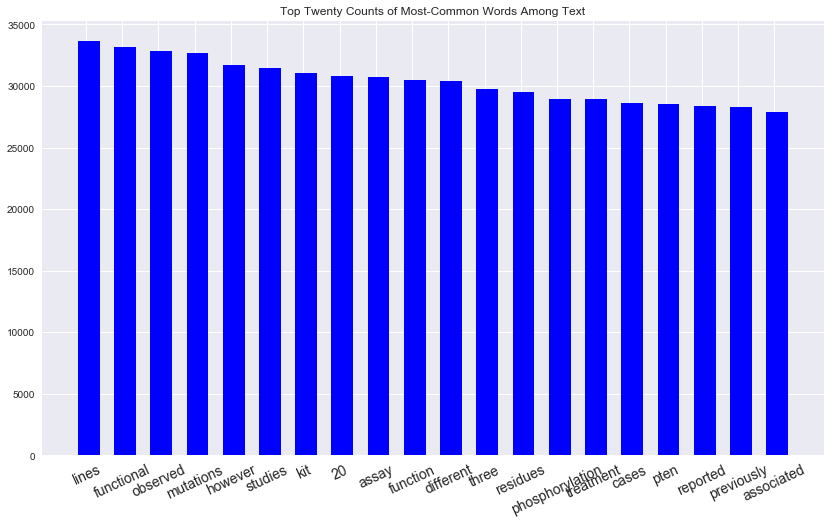

In [23]:
tops = Counter(str(trainText2).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='b')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among Text')

This looks a little more balanced so we will go with this set of texts.

In [26]:
maxFeats = 500

In [27]:
tfidf = TfidfVectorizer(min_df=5, max_features=maxFeats, ngram_range=(1,3),
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True, smooth_idf=True, sublinear_tf=True, 
                        stop_words = 'english')
tfidf.fit(trainText2)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
cvec = CountVectorizer(min_df=5, ngram_range=(1,3), max_features=maxFeats, 
                       strip_accents='unicode',
                       lowercase =True, analyzer='word', token_pattern=r'\w+',
                       stop_words = 'english')
cvec.fit(trainText2)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=5,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='\\w+', tokenizer=None,
        vocabulary=None)

_3321x8595819 sparse matrix of type 'class 'numpy.int64''
	with 38030516 stored elements in Compressed Sparse Row format_
    
This is the print output of just using nGram features 1-3. Its kind of a large item to pass around even if its sparse so limiting the maximum features helps in here.

In [33]:
## I played around with the componenets and 360-390 seemed to work best for me...
svdT = TruncatedSVD(n_components=390)
svdTFit = svdT.fit_transform(tfidf.transform(trainText2))

This is something I did in other comps that helped out some in feature building. 

In [34]:
def buildFeats(texts, variations):
    temp = variations.copy()
    print('Encoding...')
    temp['Gene'] = pd.factorize(variations['Gene'])[0]
    temp['Variation'] = pd.factorize(variations['Variation'])[0]
    temp['Gene_to_Variation_Ratio'] = temp['Gene']/temp['Variation']
    
    print('Lengths...')
    temp['doc_len'] = [len(x) for x in texts]
    temp['unique_words'] = [len(set(x))  for x in texts]
    
    print('TFIDF...')
    temp_tfidf = tfidf.transform(texts)
    temp['tfidf_sum'] = temp_tfidf.sum(axis=1)
    temp['tfidf_mean'] = temp_tfidf.mean(axis=1)
    temp['tfidf_len'] =  (temp_tfidf != 0).sum(axis = 1)
    
    print('Count Vecs...')
    temp_cvec = cvec.transform(texts)
    temp['cvec_sum'] = temp_cvec.sum(axis=1)
    temp['cvec_mean'] = temp_cvec.mean(axis=1)
    temp['cvec_len'] =  (temp_cvec != 0).sum(axis = 1)
    
    print('Latent Semantic Analysis Cols...')
    tempc = list(temp.columns)
    temp_lsa = svdT.transform(temp_tfidf)
    
    for i in range(np.shape(temp_lsa)[1]):
        tempc.append('lsa'+str(i+1))
    temp = pd.concat([temp, pd.DataFrame(temp_lsa, index=temp.index)], axis=1)
    
    return temp, tempc

In [35]:
trainDf, traincol = buildFeats(trainText2, tVars)
testDf, testcol = buildFeats(testText2, vVars)

Encoding...
Lengths...
TFIDF...
Count Vecs...
Latent Semantic Analysis Cols...
Encoding...
Lengths...
TFIDF...
Count Vecs...
Latent Semantic Analysis Cols...


In [40]:
trainDf.columns = traincol
testDf.columns = testcol

In order to get the right prediction we have to get the classes in the range of 0-8.

In [41]:
classes = tVars.Class - 1
print('Original:', Counter(tVars.Class), '\n ReHashed:', Counter(classes))

Original: Counter({7: 953, 4: 686, 1: 568, 2: 452, 6: 275, 5: 242, 3: 89, 9: 37, 8: 19}) 
 ReHashed: Counter({6: 953, 3: 686, 0: 568, 1: 452, 5: 275, 4: 242, 2: 89, 8: 37, 7: 19})


In [42]:
dft, dfv, yt, yv = train_test_split(trainDf.drop(['ID','Class'],axis=1),
                                    classes,
                                    test_size = 0.1,
                                    random_state=31415)
print(np.shape(dft))

(2988, 401)


In [43]:
import gc
print('Format a Train and Validation Set for LGB')
d_train = lgb.Dataset(dft, label=yt)
d_val = lgb.Dataset(dfv, label=yv)
               
gc.collect()

Format a Train and Validation Set for LGB


34

In [44]:
parms = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 9,
    'metric': {'multi_logloss'},
    'learning_rate': 0.05, 
    'max_depth': 7,
    'num_iterations': 1000, 
    'num_leaves': 95, 
    'min_data_in_leaf': 60, 
    'lambda_l1': 1.0,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

rnds = 260
mod = lgb.train(parms, train_set=d_train, num_boost_round=rnds,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=20,
               early_stopping_rounds=20)


C:\Users\Wegee\Anaconda3\lib\site-packages\lightgbm\engine.py:100: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[20]	dval's multi_logloss: 1.48892
[40]	dval's multi_logloss: 1.23122
[60]	dval's multi_logloss: 1.11432
[80]	dval's multi_logloss: 1.04791
[100]	dval's multi_logloss: 1.00886
[120]	dval's multi_logloss: 0.988121
[140]	dval's multi_logloss: 0.980461
[160]	dval's multi_logloss: 0.977736
[180]	dval's multi_logloss: 0.97079
Early stopping, best iteration is:
[179]	dval's multi_logloss: 0.970459


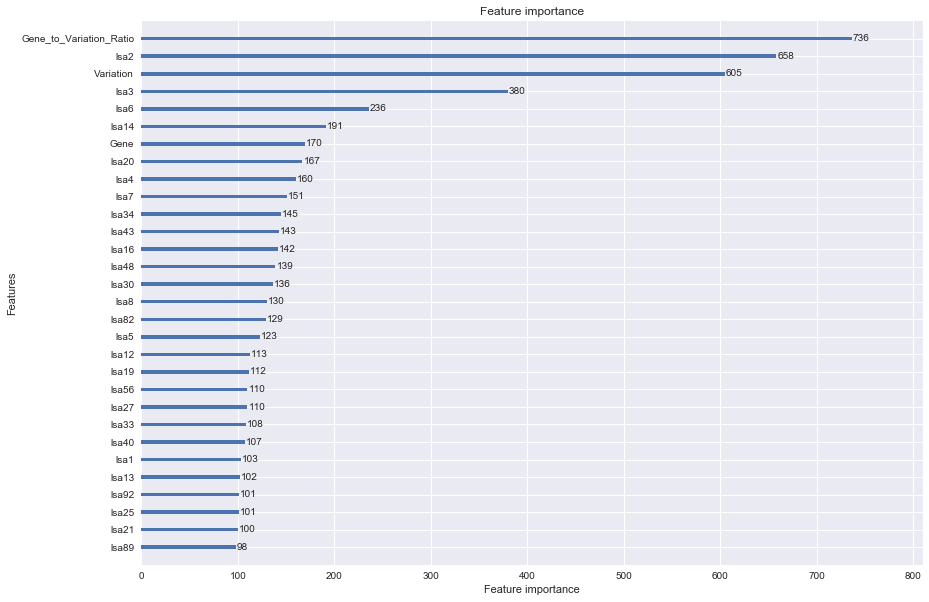

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
lgb.plot_importance(mod, max_num_features=30, figsize=(14,10))

In [46]:
pred = mod.predict(testDf.drop(['ID'],axis=1))

In [54]:
sub = pd.DataFrame(pred, index=testDf.index)
sub.columns = subfile.columns[1:]
sub.index_name = subfile.columns[0]
sub['ID'] = testDf.index+1
sub.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.915200,0.004545,0.004966,0.050377,0.009761,0.007503,0.003638,0.001650,0.002359,1
1,0.706307,0.032694,0.007598,0.127088,0.021690,0.017716,0.081879,0.002517,0.002511,2
2,0.556789,0.174612,0.006273,0.136928,0.012775,0.018320,0.085609,0.004953,0.003740,3
3,0.637412,0.096317,0.006894,0.109583,0.011720,0.008189,0.103658,0.006325,0.019902,4
4,0.236018,0.325452,0.019409,0.084979,0.042941,0.041666,0.218719,0.012966,0.017849,5


In [55]:
import datetime
now = datetime.datetime.now()
sub.to_csv('log_2nd'+str(now.strftime("%Y-%m-%d-%H-%M"))+'.csv', index=False)